In [1]:
from pathlib import Path
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

import sys, os
sys.path.insert(0, os.path.abspath('..'))

import nestor.keyword as kex
from nestor.datasets import load_excavators
import src.loss as loss
from src.opt import job_minibatch
from src.invite import sample_censored
from src.analysis import draw_G, all_thres, Record
from tqdm.autonotebook import tqdm
import matplotlib.gridspec as gridspec
from functools import partial


/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext coconut

In [4]:
net_path = Path('..')/'data'/'mine_public'

In [5]:
from utils.plot_utils import figure_setup
figure_setup()

In [6]:
df = load_excavators(cleaned=True)

def idx_to_str(input_df):
    return input_df.set_index(input_df.index.map(str))
voc1 = pd.read_excel(net_path/'vocab_aus.xlsx', 
                     index_col=0, 
                     dtype={'alias':str}).pipe(idx_to_str).fillna('')
vocab = (
    voc1
    .reset_index()
    .drop_duplicates(subset=['tokens'])
    .set_index('tokens')
)


In [7]:
df.head()

BscStartDate Asset        OriginalShorttext PMType     Cost  RunningTime  \
0   2004-07-01     A        BUCKET WON'T OPEN   PM01   183.05          NaN   
1   2005-03-20     A  L/H BUCKET CYL LEAKING.   PM01   407.40        262.0   
2   2006-05-05     A              SWAP BUCKET   PM01     0.00        411.0   
3   2006-07-11     A         FIT BUCKET TOOTH   PM01     0.00         67.0   
4   2006-11-10     A       REFIT BUCKET TOOTH   PM01  1157.27        122.0   

                  MajorSystem           Part          Action  Variant    FM  \
0                      Bucket            NaN             NaN      NaN   NaN   
1  Bucket_Hydraulic Cylinders  Cylinder_Tilt             NaN      NaN  Leak   
2                      Bucket            NaN         Replace        4   NaN   
3                      Bucket            GET         Replace  Install   NaN   
4                      Bucket            GET  Modify_Replace  Install   NaN   

  Location Comments   FuncLocation SuspSugg                           Rule  \
0      NaN      NaN         BUCKET        0                     Rule_1_3_5   
1     Left      NaN  CYLINDER BOOM        0  Rule_1_3_5_19_115_214_434_509   
2      NaN      NaN         BUCKET        0                 Rule_1_3_5_399   
3      NaN      NaN   BUCKET TEETH        0       Rule_1_3_5_8_116_132_385   
4      NaN      NaN   BUCKET TEETH        0   Rule_1_3_5_8_116_132_365_385   

  Unnamed: 16  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [8]:
vocab.head()

NE    alias                                              notes  \
tokens                                                                   
replace  S  replace    should only be used when a component is removed   
bucket   I   bucket                                                      
repair   S   repair  can mean repair but also involve replacement o...   
grease   U     lube                         to grease. Grease the noun   
leak     P     leak                      also could be failure_symptom   

            score  
tokens             
replace  0.033502  
bucket   0.018969  
repair   0.017499  
grease   0.017377  
leak     0.016591

In [9]:
# merge and cleanse NLP-containing columns of the data
known_repl = {
    'l h':'lh', 
    'r h':'rh', 
    'a c':'ac', 
    'air con':'ac',
    'rf':'right_front'
}
nlp_select = kex.NLPSelect(columns = ['OriginalShorttext'], special_replace=known_repl)
raw_text = nlp_select.transform(df)
replaced_text = kex.token_to_alias(raw_text, vocab) # raw_text, with token-->alias replacement

In [10]:
import re
from utils.excavators import extract_walk

obsv = extract_walk(replaced_text, vocab)
obsv.sample(10)

5076       [ladder, rope, position, pulley, seized]
5147         [repair, access, step, mount, bracket]
238                       [replace, chipped, tooth]
3375                        [service, guide, chain]
6                       [replace, 2, bucket, tooth]
4040                                [retract, text]
4980                     [instrument, panel, light]
2617              [replace, extinguisher, cylinder]
3800    [replace, damage, bolt, hydraulic, fitting]
1267                [replace, leak, service, point]
dtype: object

In [11]:
tex = kex.TokenExtractor()
toks = tex.fit_transform(replaced_text)

which_types = [
    'I', 
#     'P', 'S',
#     'U',
]
tag_df = kex.tag_extractor(tex, replaced_text, vocab_df=vocab)[which_types]

In [36]:
from utils.excavators import filter_tag_occurrences, filter_tag_names

filt_tags = (
    tag_df
    .droplevel(0, axis=1)
    .pipe(filter_tag_names, ['position', 'right'])
    .pipe(filter_tag_occurrences, l=2, freq=5, topn=50)
#     .pipe(filter_tag_topn, 40)
)

voc_nodes = filt_tags.columns
voc_nodes

Index(['accumulator', 'adapter', 'air', 'belt', 'bolt', 'boom', 'box', 'brake',
       'bucket', 'build', 'cap', 'clamp', 'coolant', 'cylinder', 'drain',
       'engine', 'exhaust', 'fan', 'fitting', 'gearbox', 'handrail', 'hose',
       'hydraulic', 'idler', 'light', 'line', 'lip', 'motor', 'mount', 'outer',
       'pin', 'plate', 'pump', 'radiator', 'roller', 'sensor', 'shroud',
       'slew', 'stair', 'starter', 'steel', 'step', 'switch', 'tank', 'tip',
       'tooth', 'track', 'valve', 'warranty', 'weld'],
      dtype='object')

In [37]:
from utils.excavators import mask_confusion, row_norm


subsys_cats = pd.CategoricalDtype(
    ordered=True, 
    categories= df.MajorSystem.value_counts()[:3].index.tolist()
)
    
subsys_breakdown = {
    sys:filt_tags[df.MajorSystem.str.contains(sys, na=False)].sum(axis=0) 
    for sys in df.MajorSystem.value_counts()[:3].index.tolist()
}

tag_probs = (
    pd.DataFrame()
    .assign(**subsys_breakdown)
    .pipe(row_norm)  # make class counts into "belonging" fraction
)

subsys = (
    tag_probs
    .pipe(mask_confusion)
    .idxmax(axis=1)
    .astype(subsys_cats)
)

color_dict = dict(zip(subsys.cat.categories.tolist()+[np.nan], 
                      ['dodgerblue', 'xkcd:rust','g', 'k']
                     ))
axes = tag_probs.plot.bar(subplots=True, figsize=(12,6), legend=False)

for lab in axes[2].get_xticklabels():
    sys = subsys[lab.get_text()]
    lab.set_color(color_dict[sys])
plt.tight_layout()
sns.despine()


/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [38]:
from utils.excavators import plot_tern

plt.figure()
ax=plt.subplot()
marks = plot_tern(tag_probs, subsys, 'True', color_dict, 
                  ax=ax, legend=(.8,.7), markersize=40)



In [39]:
sns.clustermap((tag_probs@tag_probs.T).fillna(0))

In [40]:

walks = extract_walk(
    replaced_text[filt_tags.index], vocab[vocab.index.isin(filt_tags.columns)]
)
walks.apply(len).describe().round(2)#.to_csv(encoding='utf8', sep='\t')
# pd.DataFrame.to_csv()

count    1712.00
mean        2.18
std         0.44
min         1.00
25%         2.00
50%         2.00
75%         2.00
max         5.00
dtype: float64

In [41]:
int_map = {i:k for k, i in enumerate(voc_nodes)}

m = [np.unique([int_map[j] for j in i]) for n,i in walks.iteritems()]

<IPython.core.display.Javascript object>


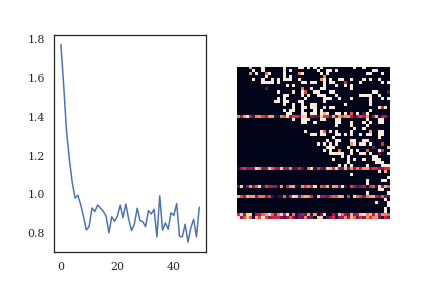

In [42]:
%matplotlib notebook
from src.models import CensoredRW, train
N = voc_nodes.shape[0]

model = CensoredRW(N, cuda=False, sym=False)
learning_rate = 0.1

train(model, np.array(m), batch_size=min(500, len(m)),# compare_true=A,
      epochs=50, callback=True, lr=learning_rate)

%matplotlib inline


In [43]:
from src.tools import cosine_model, markov_model
from src.tools import minmax, symmetrize, fill_diagonal, labeled_adj
from src.analysis import test_multi, compare_mats, compare_pvr


%coconut prep = labeled_adj$(voc_nodes)..minmax..symmetrize




res = fill_diagonal(model._symmetrize(model.P.detach()).cpu().numpy(), 0)

# res[res<0] = 0
# res = res/res.sum(axis=1)


mkv1 = markov_model(m, k=1)
mkv2 = markov_model(m, k=2)
cos = cosine_model(m)

models = dict(
    INVITE = prep(res), 
    Cosine =  prep(cos), 
    MC1 =     prep(mkv1), 
    MC2 =     prep(mkv2),
)


In [44]:


A = (tag_probs@tag_probs.T).fillna(0)#.pipe(pd_zero_diag)

plt.figure(figsize=(10,3))
compare_mats(
    None, 
#     labels=models['INVITE'].columns,
    **models
)

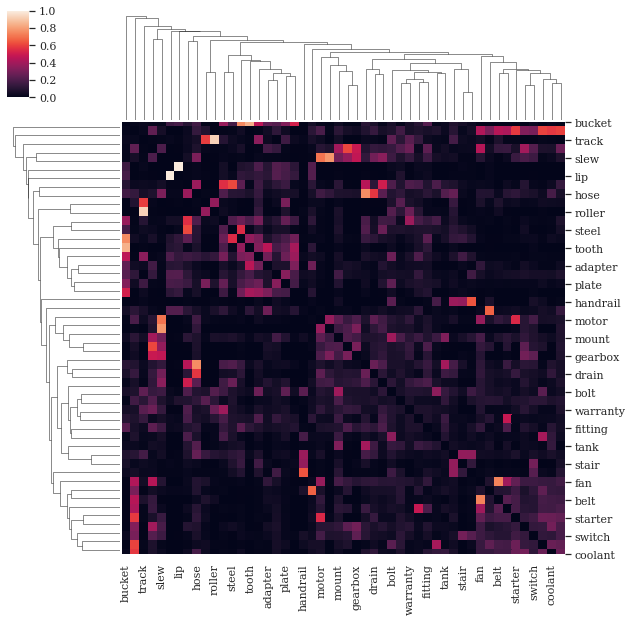

In [46]:
sns.clustermap(models['Cosine'])

In [47]:
from src.analysis import test_clf, test_multi_clf
toplvl = dict([
    ('hydraulic',  'Hydraulic System'),
#     ('hose',       'Hydraulic System'),
#     ('pump',       'Hydraulic System'),
#     ('compressor', 'Hydraulic System'),
    ('bucket',     'Bucket'), 
#     ('tooth',      'Bucket'), 
#     ('lip',        'Bucket'), 
#     ('pin',        'Bucket'), 
    ('engine',     'Engine'), 
#     ('filter',     'Engine'), 
#     ('fan',        'Engine'),
])

log = test_multi_clf(toplvl, subsys, 
                     test_kws=dict(true_prob=tag_probs, kl_opt=False, avg='weighted'), 
                     **models)

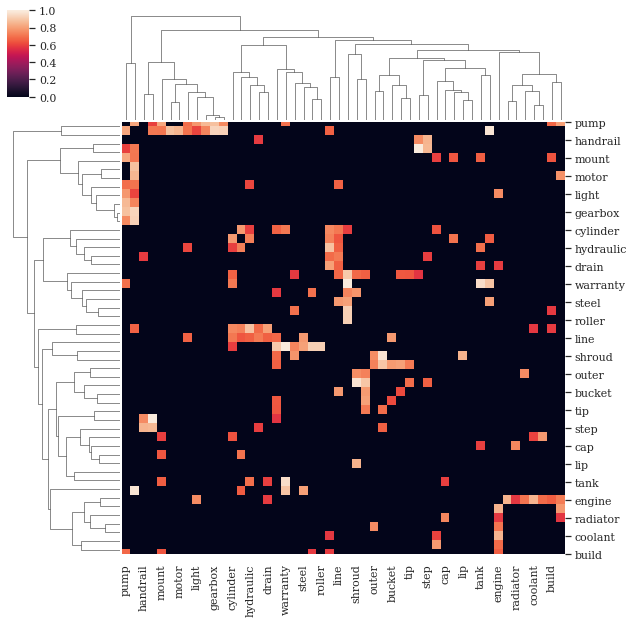

In [53]:
sns.clustermap(log['INVITE']['thres'], method='ward')

0
1
2
3
4


IndexError: list index out of range

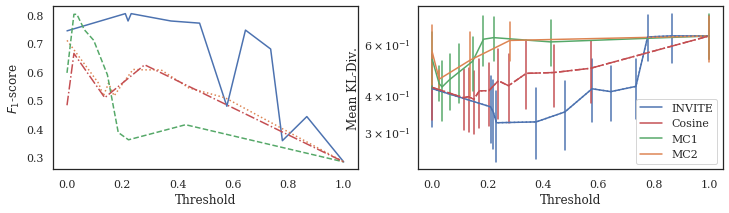

In [108]:
from cycler import cycler
custom_cycler = (cycler(color=sns.color_palette(n_colors=4)) +
                 cycler(ls=['-', ':', '--', '-.']))

fig, ax = plt.subplots(ncols=2, sharey=False, figsize=(12,3))
for axis in ax:
    axis.set_prop_cycle(custom_cycler)
for n, (name, d) in enumerate(log.items()):
    ax[0].plot(d['t'], d['f'], label=name)
#     ax[0].legend(loc=0)
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('$F_1$-score')
#     μ =  np.nanmean(d['kl_vals'], axis=1)
#     ax[1].plot(d['t'],μ, label=name)
    ts = (
        pd.DataFrame(d['kl_vals'], index=d['t'])
        .reset_index()
        .melt(id_vars='index')
        .astype(float)
    )

    sns.lineplot(data=ts, x='index', y='value', 
                 label=name, estimator=np.nanmean,
                 err_style='bars', ax=ax[1])
    
    ax[1].set_yscale('log')
    ax[1].legend(loc=0)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Mean KL-Div.')
    σ = np.nanstd(d['kl_vals'], axis=1)
#     lower, upper = μ - σ, μ + σ
#     med, lower, upper = (np.percentile(d['kl_vals'][:,(~np.isnan(d['kl_vals'])).any(axis=0)], i, axis=1) for i in [50, 25, 75])
#     plt.plot(d['t'], med, label=name)
#     ax[1].fill_between(d['t'], lower, upper, alpha=.1)
#     ax[1].plot(d['t'], σ, '--')
#     plt.errorbar(d['t'], μ, yerr=σ)
    
#     plt.xlim(0,1)
for n, lin in enumerate(ax[1].lines):
    print(n)
    lin.set_linestyle(list(custom_cycler)[n]['linestyle'])
sns.despine()

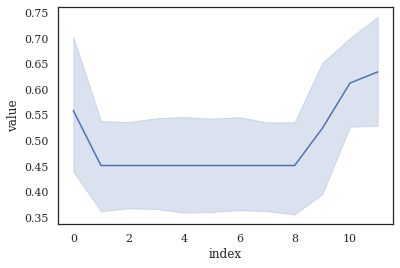

In [49]:
import matplotlib
matplotlib.# ts

(0.0, 1.0, 0.0, 1.0)

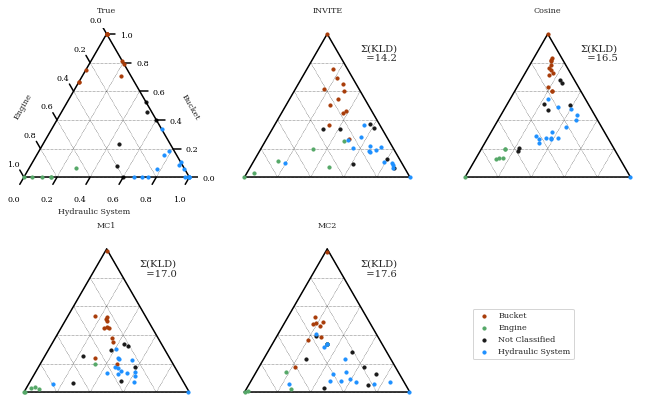

In [24]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(1.6*7, 7),
                         gridspec_kw=dict(hspace=.3, wspace=.2))
plot_tern(tag_probs, subsys, 'True', color_dict,
          ax=ax.flatten()[0], info=True)

for n, (name, d) in enumerate(log.items()):
    axis = ax.flatten()[n + 1]
    legend = False
    if n == 3:
        legend = (1.3, .3)
    plot_tern(d['probs'], subsys, name,
              color_dict, ax=axis, legend=legend, info=False)
    axis.text(
        .7, .7, f'Σ(KLD)\n  ={np.nansum(d["kl_vals"][d["opt_pos"]]):.1f}',
#         fontsize=pu.font_size(),
    )
for axis in ax.flatten():
    axis.set_aspect(1.)
#                                     f'{np.nanstd(d["kl_vals"][d["opt_pos"]]):.2f}'))

#     ax.flatten()[n+1].text(70,80., (f'KL-IQR: {np.percentile(d["kl_vals"][d["opt_pos"]], 25):.2f} - '
#                                     f'{np.percentile(d["kl_vals"][d["opt_pos"]],75):.2f}'))
ax.flatten()[-1].axis('off')

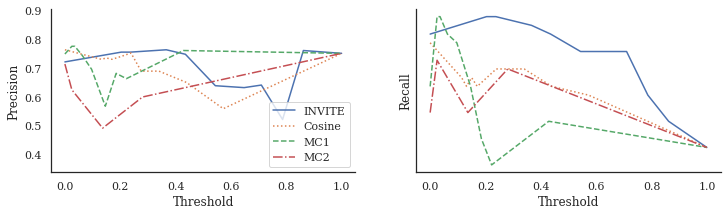

In [57]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12,3))
for axis in ax:
    axis.set_prop_cycle(custom_cycler)
    
for name, d in log.items():
    ax[0].plot(d['t'], d['p'], label=name)
    ax[0].legend(loc=0)
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Precision')
    ax[1].plot(d['t'], d['r'], label=name)
#     ax[1].legend(loc=0)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Recall')
#     plt.xlim(0,1)
sns.despine()

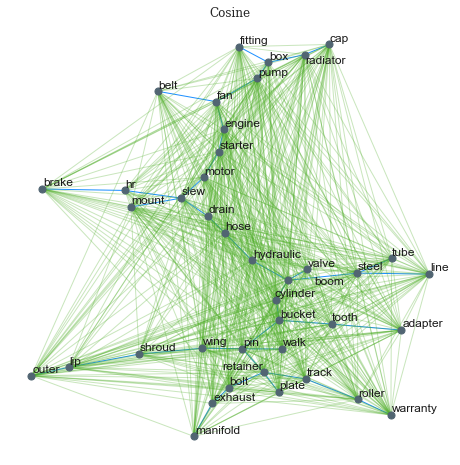

In [80]:
# from lib.analysis import all_thres, draw_G, pvr_plot
# from adjustText import adjust_text()

# from mpl_toolkits.axes_grid1 import AxesGrid

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# for n, (axis,which) in enumerate(zip(ax.flatten(),log))
which = 'Cosine'
def mstree_plot(A_thres, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    G = nx.from_pandas_adjacency(
        A_thres,
        create_using=nx.Graph
    )
    G = nx.convert_node_labels_to_integers(G, label_attribute='item')
    D = nx.maximum_spanning_tree(G)

    nontree_edges = nx.from_numpy_array(
        nx.to_numpy_array(G) - nx.to_numpy_array(D) > 0, 
        create_using=nx.Graph
    )
    pos = nx.layout.kamada_kawai_layout(D)
    if title is not None:
        ax.set_title(title)
    draw_G(D, pos, withlabels=True, fp=nontree_edges, legend=False, ax=ax)
    
#     print(f'C_β = {nx.average_clustering(G):.2f}')
    ax.axis('off')
    ax.set_clip_on(False)

plt.figure(figsize=(8,8))
mstree_plot(log[which]['thres'], title=which)

# Sandbox

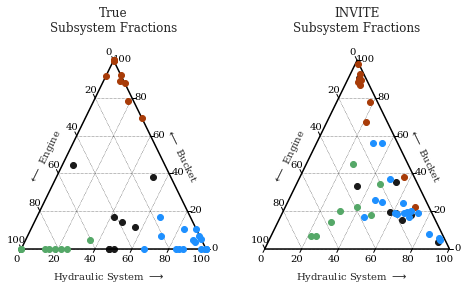

In [547]:
from networkx import node_classification
from lib.tools import local_and_global_consistency, softmax
from scipy.stats import entropy
from scipy.optimize import minimize_scalar

toplvl = dict([
    ('hydraulic',  'Hydraulic System'),
    ('hose',       'Hydraulic System'),
    ('pump',       'Hydraulic System'),
    ('compressor', 'Hydraulic System'),
    ('bucket',     'Bucket'), 
    ('tooth',      'Bucket'), 
    ('lip',        'Bucket'), 
    ('pin',        'Bucket'), 
    ('engine',     'Engine'), 
    ('filter',     'Engine'), 
    ('fan',        'Engine'),
])

for k,v in toplvl.items():
    if k in G.node.keys():
        G.node[k]['label'] = v

pred_labels, pred = local_and_global_consistency(G)


def kl_div(λ):
    prob = softmax(λ*pred[tag_probs.columns])
    kl = entropy(tag_probs.T, prob.T)
    return kl.sum()

opt_kl = minimize_scalar(kl_div)

K = opt_kl['x']
pred_prob = softmax(K*pred[tag_probs.columns])



# entropy(tag_probs.T, pred_prob.T)
sys_comp = (pd.DataFrame({
        'truth':subsys, 
        'predicted':dict(zip(
            [i for i in G.nodes()],
    #         node_classification.local_and_global_consistency(G)
            pred_labels
        )),
        'KL': dict(zip(
            [i for i in G.nodes()],
            pd.Series(entropy(tag_probs.T, pred_prob.T))
        )),
    }).astype({'truth':subsys_cats, 'predicted':subsys_cats, 'KL':float})
)



f, ax = plt.subplots(ncols=2, figsize=(8,4))

plot_tern(tag_probs, subsys, 'True', color_dict, ax=ax[0])
plot_tern(pred_prob, subsys, which, color_dict, ax=ax[1])
# sys_comp


# sns.distplot()

In [627]:
from lib.analysis import test_multi_kl
kl_log = test_multi_kl(toplvl, tag_probs, **models)

# plot_tern(kl_log['probs'], subsys, color_dict)




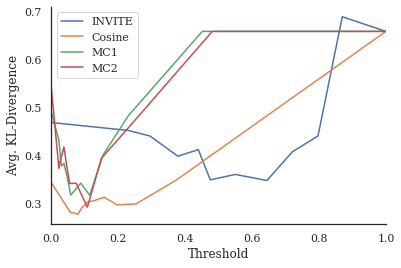

In [628]:
for name, d in kl_log.items():
    med, lower, upper = (np.percentile(d['kl_vals'], i, axis=1) for i in [50, 25, 75])
    plt.plot(d['t'], med, label=name)
#     plt.fill_between(d['t'], lower, upper, alpha=.1)
#     plt.plot(d['t'], d['temps'], label=name)
    plt.legend(loc=0)
    plt.xlabel('Threshold')
    plt.ylabel('Avg. KL-Divergence')
    plt.xlim(0,1)
sns.despine()

# plt.plot(kl_log['t'], kl_log['kl_vals'].sum(axis=1))

NameError: name 'kl_log' is not defined

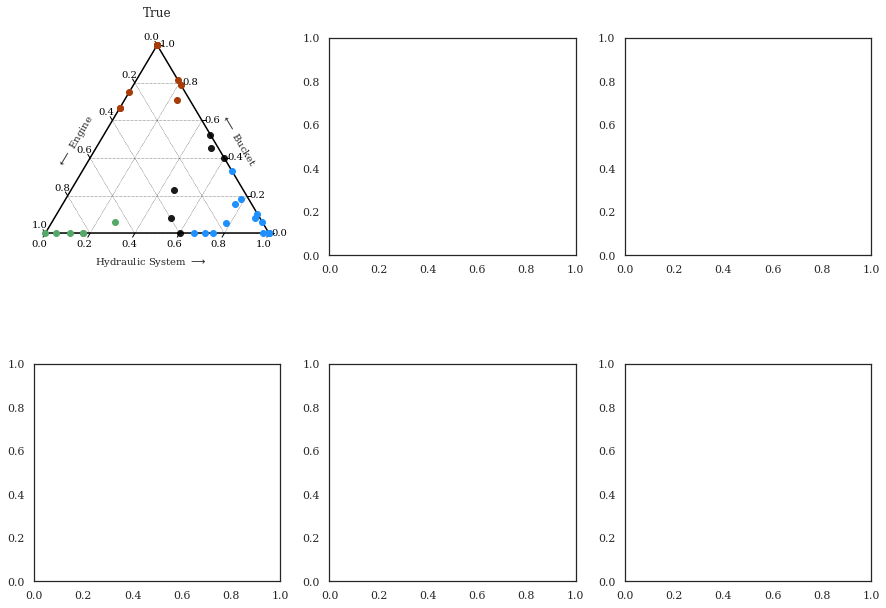

In [51]:
f, ax = plt.subplots(ncols=3,nrows=2, figsize=(15,10), gridspec_kw=dict(hspace=.5))
plot_tern(tag_probs, subsys, 'True', color_dict, ax=ax.flatten()[0])

for n, (name, d) in enumerate(kl_log.items()):
    
    k = plot_tern(d['probs'], subsys, name, color_dict, ax=ax.flatten()[n+1])
    if n==3:
        plt.legend()
    ax.flatten()[n+1].text(70,80., (f'μKLD={d["kl_vals"][d["opt_pos"]].mean():.2f}±'
                                    f'{d["kl_vals"][d["opt_pos"]].std():.2f}'))
    
ax.flatten()[-1].axis('off')
plt.tight_layout()

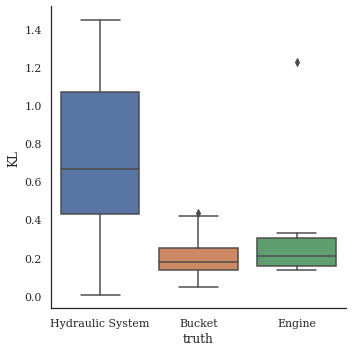

In [513]:
sns.catplot(x='truth', y='KL', data=sys_comp, kind='box')

In [280]:
from lib.analysis import test, get_threslist
from lib.tools import softmax
# test(sys_comp.true.)



def check_sensitivity(X, thres):
    """Warps values in X to scale from 0,100
    then determines whether their softmax displays
    a difference between top-two of at least `thres`. 
    """
    arg_sort = np.argsort(-X, axis=1)
# pred_prob[:,arg_sort[:,0]] - pred_prob[:,arg_sort[:,1]]
    X_sort = softmax(100*minmax(np.take_along_axis(X, arg_sort, axis=1)))
    print(X_sort[:,0] - X_sort[:,1])
    return X_sort[:,0] - X_sort[:,1] >= thres

# check_sensitivity(pred_prob, 0.2)
# d = test(pd.get_dummies(sys_comp.true).values, pred_prob)
# plt.plot(d['t'], d['f'])
# def get_threslist(X):
#     """Smooth list of thresholds by uniform quantile samples.
#     Samples 0th, 50th, 55th 60th...100th quantile.
#     ignores trivial/base-case entries of zero for sparse matrices.
#     """
#     qlist = np.linspace(50,100, num=11)
#     non_z_vals = X.flatten()[X.flatten()!=0]
#     return np.array([0.]+[np.percentile(non_z_vals, q) for q in qlist])

# np.array([np.percentile(models['INVITE'], q) for q in np.linspace(50,100, num=11)])
# for t in get_threslist(models['Cosine']):
#     print(check_sensitivity(pred_prob, t))

Honestly, I should ignore the prediction of "nan"s. While definitely useful, I'm more interested in the signal detection itself.... all of this softmax shennanigans is possible but adds a ton of extra parameters to test and/or train. 


In [281]:
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, average_precision_score, precision_recall_fscore_support, precision_recall_curve
y1, y2 = sys_comp.true.cat.codes, sys_comp.predicted.cat.codes

# adjusted_mutual_info_score(sys_comp.true, sys_comp.predicted)
print(adjusted_mutual_info_score(
    y1, y2,
    average_method='arithmetic'
))

sns.heatmap(confusion_matrix(y1, y2, labels=[0,1,2]), annot=True)
precision_recall_fscore_support(y1, y2, average='weighted', labels=[0,1,2]), accuracy_score(y1, y2)
# plt.tight_layout()

0.08557002420774991


((0.5251231527093596, 0.6571428571428571, 0.5628315094153603, None),
 0.5348837209302325)

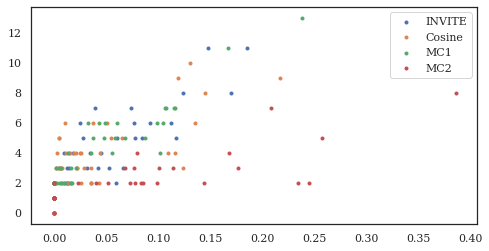

In [649]:
# plt.scatter(
#     nx.betweenness_centrality(G).values(),
#     zip(*list(nx.degree(G)))[1]
# )

plt.figure(figsize=(8,4))
for mod in log.keys():
    
    D = nx.from_numpy_array(log[mod]['thres'].values)

#     path = lambda n: np.array(list(
#         dict([(k,v) for k,v in nx.single_target_shortest_path_length(D, n) if k is not n])
#         .values()
#     )).mean()
    plt.scatter(list(nx.betweenness_centrality(D).values()),
                zip(*list(nx.degree(D)))[1], 
                label=mod, marker='.')
    
plt.legend()

In [123]:
# from networkx.utils import groups

def thres_voronoi_cells(G, center_nodes, thres=None, weight='weight'):

    # Determine the shortest paths from any one of the center nodes to
    # every node in the graph.
    #
    # This raises `ValueError` if `center_nodes` is an empty set.
    paths = nx.multi_source_dijkstra_path(G, center_nodes, weight=weight)
    
    # Determine the center node from which the shortest path originates.
    if thres is not None:
        thres_cond = lambda p: len(p)>1 and (p[1]-p[0]>thres)
    else:
        thres_cond = lambda p: True
    nearest = {v: p[0] for v, p in paths.items() if thres_cond(p)}
    print(nearest)
    # Get the mapping from center node to all nodes closer to it than to
    # any other center node.
    cells = nx.utils.groups(nearest)
    # We collect all unreachable nodes under a special key, if there are any.
    unreachable = set(G) - set(nearest)
    if unreachable:
        cells['unreachable'] = unreachable
#         cells['uncertain'] = uncertain
    return cells

thres_voronoi_cells(G, [int_map['hydraulic'], int_map['engine']], thres=2)

{13: 9, 16: 9, 18: 9, 19: 14, 21: 9, 22: 9, 24: 14, 26: 9, 27: 9, 29: 14, 30: 9, 20: 14, 4: 14, 5: 14, 6: 9, 23: 14, 25: 14, 17: 9, 28: 9}


{9: {6, 13, 16, 17, 18, 21, 22, 26, 27, 28, 30},
 14: {4, 5, 19, 20, 23, 24, 25, 29},
 'unreachable': {3, 8, 9, 10, 11, 12, 14, 15}}

In [176]:
%%coconut 
import toolz as tz
from typing import Iterable, FrozenSet, Set


def int_to_name(s is int) = 
    """ tired of looping this, so I'm making a 
    recursive applier to map int -> node name"""
    s |> name_map[]  # base case, int to name
    
@addpattern(int_to_name)
def int_to_name(s is Iterable) =  
    # if iterable, repeat
    s |> fmap$(int_to_name) # yay recursion! 

# tags that represent subsystems (Sexton et al 2018, PHM Society)
top3 = {'hydraulic', 'bucket', 'engine'}

d = ((G, top3|>fmap$(int_map[]))  # use ints, not names
 |*> nx.voronoi_cells$(weight=None)  # treat these as "centers" for cells
 |> tz.keyfilter$((!=)$('unreachable'))  # only reachable nodes
 |> tz.itemmap$(int_to_name)  # recursively rename ints to names
)

def mask_toplvl(input_df, toplvl) = 
    input_df.mask(~input_df.isin(input_df[list(toplvl.keys())])) 

def rename_toplvl(input_df, toplvl) = 
    (input_df
     .map(toplvl)
     .astype(subsys_cats)
    )

def apply_toplvl(input_df):
    toplvl = dict([('hydraulic', 'Hydraulic System'), 
                   ('bucket', 'Bucket'), 
                   ('engine', 'Engine')])
    
    return (input_df
            .pipe(mask_toplvl, toplvl)
            .pipe(rename_toplvl, toplvl)
    )

newsys = (
    pd.DataFrame([(t, k) for k, v in d.items() for t in v])
    .set_index(0)[1]
    .pipe(apply_toplvl)
)

sys_comp = pd.DataFrame({'true':subsys, 'predicted':newsys})

sys_comp

true         predicted
adapter              Bucket            Bucket
air                  Engine            Engine
bolt                    NaN            Bucket
boom       Hydraulic System  Hydraulic System
box        Hydraulic System            Engine
brake      Hydraulic System            Engine
bucket               Bucket            Bucket
coolant              Engine            Engine
cylinder                NaN            Bucket
engine               Engine            Engine
exhaust              Engine            Engine
fan                     NaN            Engine
fitting                 NaN  Hydraulic System
hose       Hydraulic System            Engine
hydraulic  Hydraulic System  Hydraulic System
light                Engine            Engine
line                 Bucket            Bucket
lip                  Bucket            Bucket
motor      Hydraulic System            Engine
mount      Hydraulic System  Hydraulic System
pin                  Bucket            Bucket
pump       Hydraulic System  Hydraulic System
radiator                NaN            Engine
roller     Hydraulic System            Bucket
slew       Hydraulic System            Engine
step       Hydraulic System            Engine
switch                  NaN  Hydraulic System
tank       Hydraulic System  Hydraulic System
tooth                Bucket            Bucket
track      Hydraulic System            Bucket
valve      Hydraulic System  Hydraulic System

In [74]:
sim = nx.simrank_similarity(G)
lol = [[sim[u][v] for v in sorted(sim[u])] for u in sorted(sim)]
sim_array = np.array(lol)
sns.clustermap(sim_array - np.diag(np.diag(sim_array)))

In [165]:
%%coconut

# import itertools
# communities_generator = nx.community.girvan_newman(G)
# communities_generator = nx.community.label_propagation_communities(G)
# communities_generator = nx.community.asyn_fluidc(G, 3)
communities_generator = nx.community.greedy_modularity_communities(G, weight='weight')
# communities_generator = nx.community.asyn_lpa_communities(G, weight='weight')

communities = list(communities_generator)

d = communities |> (map$..map$)(name_map[]) |>map$(list) |> dict..enumerate

def mask_toplvl(input_df, toplvl) = 
    input_df.mask(~input_df.isin(input_df[list(toplvl.keys())])) 

def rename_toplvl(input_df, toplvl) = 
    old_cats = dict(
        [(j,toplvl[i]) for i,j in input_df[
            list(toplvl.keys())[::-1]  # make Hyd top priority
        ].items()]
    )
    (input_df
     .map(old_cats)
     .astype(pd.CategoricalDtype(toplvl.values(), ordered=True))
    )

def apply_toplvl(input_df):
    
    toplvl = dict([('hydraulic', 'Hydraulic System'), 
                   ('bucket', 'Bucket'), 
                   ('engine', 'Engine')])
    

    return (input_df
            .pipe(mask_toplvl, toplvl)
            .pipe(rename_toplvl, toplvl)
    )

newsys = (
    pd.DataFrame([(t, k) for k, v in d.items() for t in v])
    .set_index(0)[1]
    .pipe(apply_toplvl)
)

sys_comp = pd.DataFrame({'true':subsys, 'predicted':newsys})

sys_comp

# {n:[isin_check(i, com) for com in communities ] for n,i in toplvl}



true         predicted
adapter              Bucket  Hydraulic System
air                  Engine  Hydraulic System
bolt                    NaN  Hydraulic System
boom       Hydraulic System  Hydraulic System
box        Hydraulic System  Hydraulic System
brake      Hydraulic System  Hydraulic System
bucket               Bucket  Hydraulic System
coolant              Engine               NaN
cylinder                NaN  Hydraulic System
engine               Engine  Hydraulic System
exhaust              Engine  Hydraulic System
fan                     NaN  Hydraulic System
fitting                 NaN  Hydraulic System
hose       Hydraulic System  Hydraulic System
hydraulic  Hydraulic System  Hydraulic System
light                Engine  Hydraulic System
line                 Bucket  Hydraulic System
lip                  Bucket  Hydraulic System
motor      Hydraulic System  Hydraulic System
mount      Hydraulic System  Hydraulic System
pin                  Bucket  Hydraulic System
pump       Hydraulic System  Hydraulic System
radiator                NaN  Hydraulic System
roller     Hydraulic System  Hydraulic System
slew       Hydraulic System  Hydraulic System
step       Hydraulic System  Hydraulic System
switch                  NaN  Hydraulic System
tank       Hydraulic System  Hydraulic System
tooth                Bucket  Hydraulic System
track      Hydraulic System  Hydraulic System
valve      Hydraulic System  Hydraulic System

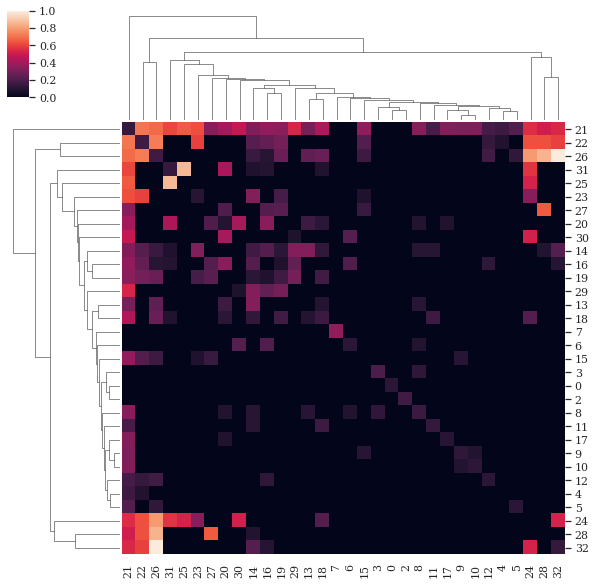

In [38]:
sns.clustermap(nx.to_pandas_adjacency(G))

# OLD (autograd)

In [48]:
from lib.opt import job_minibatch, Record
%matplotlib notebook


# B = np.random.rand(*(len(voc_nodes), len(voc_nodes)))
# B = B.T + B - 2*np.diag(B.diagonal())

rec = Record()
sym=True

A_approx = job_minibatch(loss.loss, cos.values, m,
                         epochs=5,
                         learning_rate=.9,
                         batch_size=5,
#                          reg=.01,
                         sym=sym,
                         decay=True,
                         avg=True,
                         callback=rec.err_and_mat)

%matplotlib inline

<IPython.core.display.Javascript object>

In [18]:
# np.save('A_approx-20190215', A_approx)
A_approx = np.load('A_approx-20190215.npy')

Threshold = 1.4507e-02


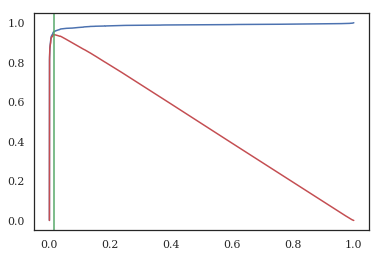

In [19]:
from lib.analysis import all_thres, draw_G

# A_thres = loss._symmetrize(all_thres(A_approx))
thres_val, A_thres = all_thres(A_approx, pct_thres=None)
# A_thres = loss._symmetrize(np.where(A_approx>.1, 1.,0.))

In [20]:
# thres_val = np.where(A_thres==1., A_approx, np.inf).min()
plt.imshow(A_thres)

C_β = 0.10


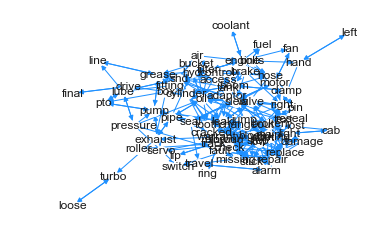

In [21]:
name_map = {k:i for k, i in enumerate(voc_nodes)}
G = nx.from_numpy_array(np.where(A_approx>thres_val, np.log(2+A_approx),0), create_using=nx.DiGraph)
G.remove_nodes_from(list(nx.isolates(G)))

nx.set_node_attributes(G, name_map, 'item')

pos = nx.layout.kamada_kawai_layout(G)
# pos = nx.layout.spring_layout(G)
draw_G(G, pos, withlabels=True)
print(f'C_β = {nx.average_clustering(G):.2f}')

In [22]:
# adj_ivt = filt_tags.T.dot(filt_tags)
# adj_ivt.loc[:,:] = A_approx
adj_ivt = pd.DataFrame(data=A_approx, columns=voc_nodes, index=voc_nodes)

# adj_ivt.values[[np.arange(len(adj_ivt))]*2] = np.nan

# edgelist = adj_ivt.stack().mask(adj_ivt.stack()<7.5519e-02, other=np.nan).reset_index()
# edgelist = edgelist[edgelist[0].notna()].reset_index(drop=True)
# edgelist.columns = ['source', 'target', 'weight']


# adj_ivt.index = adj_ivt.index.droplevel()
# adj_ivt.columns = adj_ivt.columns.droplevel()

# dir_mat = adj_ivt.mask(adj_ivt<4.1e-2, other=0.)

In [23]:
def induced_digraph(adj, thres_val, node):
    I = nx.DiGraph(adj_ivt.mask(adj_ivt<thres_val, other=0.))
    I = nx.compose(nx.edge_subgraph(I, I.in_edges(node)),
                   nx.edge_subgraph(I, I.out_edges(node)))
    return I

def induced_graph(adj, thres_val, node):
    I = nx.Graph(adj_ivt.mask(adj_ivt<thres_val, other=0.))
    I = nx.edge_subgraph(I, I.edges(node))
    return I

def induced_graph_plot(adj, thres_val, node, **opts_kws):
    I = induced_digraph(adj, thres_val, node)
    opts = dict(
        node_size=10, 
#         node_fill_color=None,
#         node_line_color=None,
#         arrowhead_length=0.02,
#         directed=True,
    )
    opts.update(opts_kws)
    graph = hv.Chord.from_networkx(I, nx.layout.shell_layout).opts(**opts)
    return graph
viz_nodes = [['replace', 'repair'], ['tooth', 'bucket'], ['leak', 'pump'], ['fan']]
# labels = hv.Labels(graph.nodes, ['x', 'y'], 'index')

# * labels.opts(text_font_size='10pt', text_color='k')
g_plot = partial(induced_graph_plot, adj_ivt, thres_val)

hv.Layout([g_plot(i).relabel(', '.join(i)) for i in viz_nodes]).opts(
    opts.Chord(
        cmap='Category20', 
        edge_cmap='Category20', 
        edge_color=dim('start').str(), 
        labels='index', 
        node_color=dim('index').str(),
        show_legend=False,
#         aspect=2.,
#         edge_line_width=hv.dim('weight').sum(),
    )#, opts.Layout(sizing_mode='scale_width')
).cols(2)
#     opts.Chord(edge_color='weight', cmap='Set1', edge_alpha=0.5,
#                edge_cmap='viridis', edge_line_width=hv.dim('weight')*10))
# hv.dim.

:Layout
   .Chord.Replace_comma_repair :Chord   [start,end]   (weight)
   .Chord.Tooth_comma_bucket   :Chord   [start,end]   (weight)
   .Chord.Leak_comma_pump      :Chord   [start,end]   (weight)
   .Chord.Fan                  :Chord   [start,end]   (weight)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
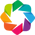

:Overlay
   .Graph.I  :Graph   [start,end]   (weight)
   .Labels.I :Labels   [x,y]   (item)

In [24]:
hv.extension('bokeh')
graph = hv.Graph.from_networkx(G, nx.layout.kamada_kawai_layout).opts(opts.Graph(
    edge_cmap='magma',
    node_size=None,
#     labels='index'
    directed=False,
    edge_color=dim('weight'),
    edge_alpha=dim('weight')
))

labels = hv.Labels(graph.nodes, ['x', 'y'], 'item')
graph*labels

In [82]:
cos_thres = cos.copy()
# cos_thres.columns = cos_thres.columns
# cos_thres.index = cos_thres.index.droplevel()
cthres_val, cos_thres.loc[:,:] = all_thres(cos.values, pct_thres=None)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


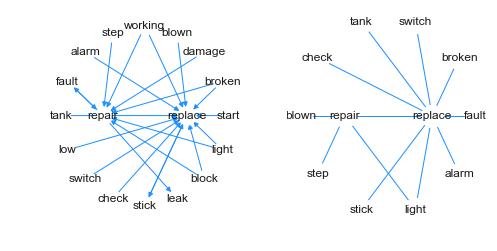

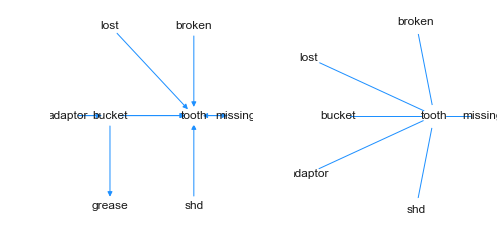

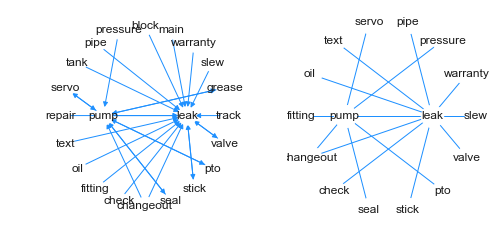

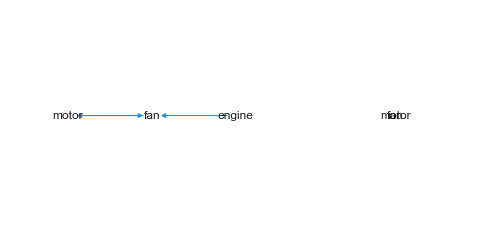

In [26]:


viz_nodes = [['replace', 'repair'], ['tooth', 'bucket'], ['leak', 'pump'], ['fan']]

induced = partial(induced_digraph, adj_ivt, thres_val)
induced_c = partial(induced_graph, cos, cthres_val)
for nodes in viz_nodes:
    g = induced(nodes)
    pos_g = nx.shell_layout(
        g, nlist=[nodes, list(set(g.nodes).difference(nodes))]
    )
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    nx.draw_networkx(g, pos_g, node_size=300., node_color='w', edge_color='dodgerblue')
    plt.axis('off')
    
    c = induced_c(nodes)
    pos_c = nx.shell_layout(
        c, nlist=[nodes, list(set(c.nodes).difference(nodes))]
    )
    plt.subplot(122)
    nx.draw_networkx(c, pos_c, node_size=500., node_color='w', edge_color='dodgerblue')
    plt.axis('off')

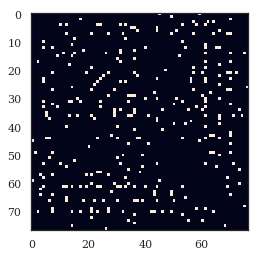

In [27]:
# cthres_val = np.where(cos_thres==1., cos, np.inf).min()
plt.imshow(cos_thres)

/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


C_β = 0.32


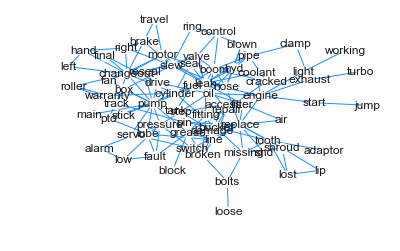

In [28]:
cosG = nx.from_numpy_array(cos_thres.values)
nx.set_node_attributes(cosG, name_map, 'item')
cosG.remove_nodes_from(list(nx.isolates(cosG)))
draw_G(cosG, pos=nx.layout.kamada_kawai_layout(cosG), withlabels=True)
print(f'C_β = {nx.average_clustering(cosG):.2f}')

In [29]:
# * labels.opts(text_font_size='10pt', text_color='k')
c_plot = partial(induced_graph_plot, cos, cthres_val)

hv.Layout([c_plot(i).relabel(', '.join(i)) for i in viz_nodes]).opts(
    opts.Chord(
        cmap='Category20', 
        edge_cmap='Category20', 
        edge_color=dim('start').str(), 
        labels='index', 
        node_color=dim('index').str(),
        show_legend=False,
#         aspect=2.,
#         edge_line_width=hv.dim('weight').sum(),
    )#, opts.Layout(sizing_mode='scale_width')
).cols(2)

:Layout
   .Chord.Replace_comma_repair :Chord   [start,end]   (weight)
   .Chord.Tooth_comma_bucket   :Chord   [start,end]   (weight)
   .Chord.Leak_comma_pump      :Chord   [start,end]   (weight)
   .Chord.Fan                  :Chord   [start,end]   (weight)

In [63]:
# cent = pd.Series(nx.closeness_centrality(G))
cent = pd.Series(nx.pagerank(G))
order=(cent
    .sort_values(ascending=False)
    .index.tolist()
)


def sort_spy(A, order, ax=None, **kws):
    if ax is None:
        f = plt.figure()
        ax = plt.gca()
    a = A[order,:][:,order]
    
    ax.spy(a, **kws)


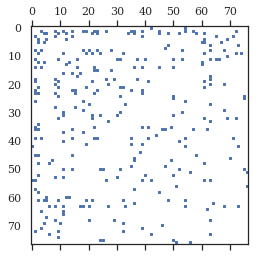

In [64]:
sort_spy(cos_thres.values, order, markersize=2,)

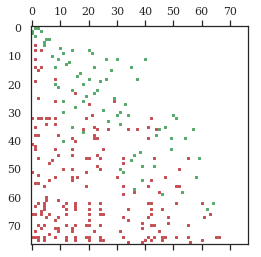

In [65]:
f = plt.figure()
ax = plt.gca()
sort_spy(np.minimum(A_thres, A_thres.T), order, ax=ax,
         markersize=2, color='g')
sort_spy(A_thres - np.minimum(A_thres, A_thres.T), order, ax=ax, 
         markersize=2, color='r')

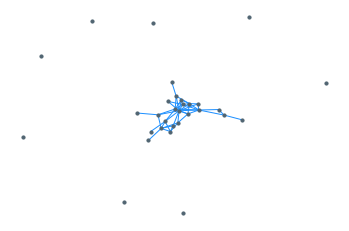

In [80]:
ivt_thres = np.minimum(A_thres, A_thres.T)
# ivt_thres = np.maximum(A_thres, A_thres.T)
# symG = nx.from_numpy_array(ivt_thres)
symG = nx.from_numpy_array(ivt_thres)
nx.set_node_attributes(symG, name_map, 'item')

draw_G(symG, nx.spring_layout(symG), withlabels=False)

/home/tbsexton/anaconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


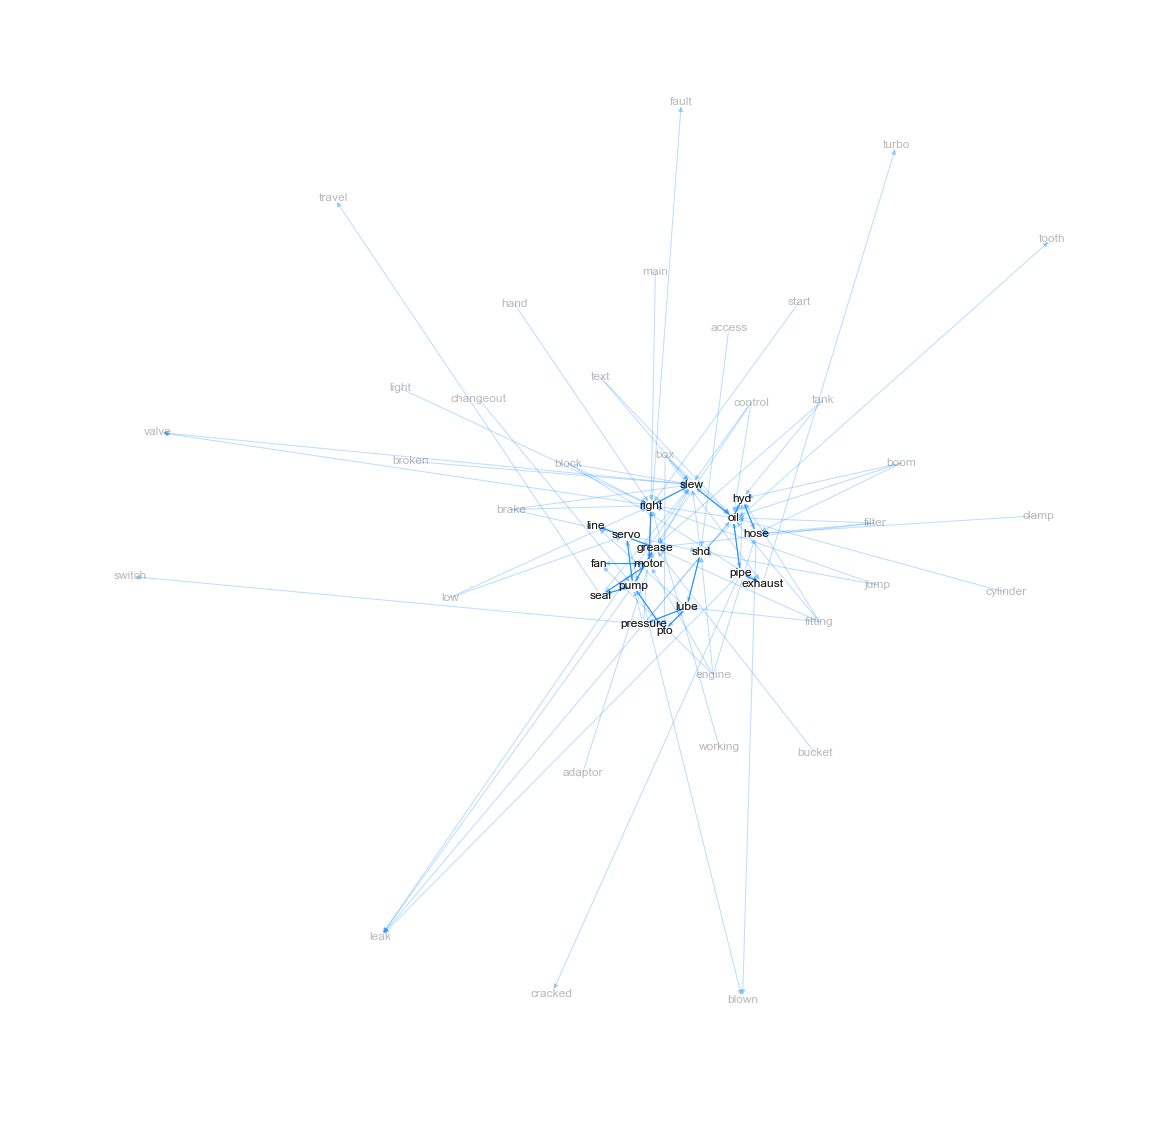

In [121]:
subg = [symG.subgraph(c) for c in nx.connected_components(symG)]
for n, d in enumerate(sorted(subg, key=len, reverse=True)):
    if len(d)>4:
        I = nx.DiGraph(A_thres)
        nx.set_node_attributes(I, name_map, 'item')
        I = nx.compose(nx.edge_subgraph(I, I.in_edges(d)),
                       nx.edge_subgraph(I, I.out_edges(d)))
        
        plt.figure(figsize=(20,20))
#         plt.subplot(121)
        posd = nx.spring_layout(d, k=1.)
        draw_G(d, posd, withlabels=True)
        init = nx.spring_layout(I, k=1.)
        init.update(posd)
        draw_G(I, nx.spring_layout(I, pos=init, fixed=list(d.nodes), k=1.),
               withlabels=True, alpha=.3)
        
#         plt.subplot(122)
#         draw_G(cosG.subgraph(d), nx.kamada_kawai_layout(cosG.subgraph(d)), withlabels=True)

NameError: name 'cos_thres' is not defined

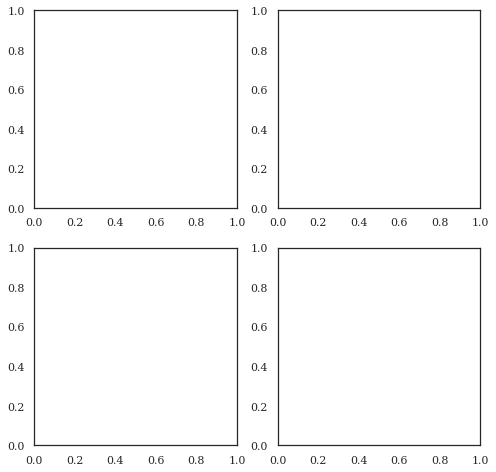

In [81]:
f,axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

def cent_order(G, cut=None):
    cent = pd.Series(nx.pagerank(G))
    if cut is not None:
        cent=cent[cent<cent.quantile(cut)]
    order=(cent
        .sort_values(ascending=False)
        .index.tolist()
    )
    return order

for n,ax in enumerate(axes[:,0].flatten()):
    sort_spy([
        ivt_thres,
        cos_thres.values,
    ][n],
        order=list(map(cent_order, [symG, cosG]))[n],
        ax=ax)
    ax.axis('off')
    ax.set_title([
        '$\mathbf{M}^{\sigma}$ - INVITE',
        '$\mathbf{M}^{\sigma}$ - Cosine',
    ][n])

cut_order=(cent[cent<cent.quantile(.75)]
    .sort_values(ascending=False)
    .index.tolist()
)
# cut_rm=(cent[cent>=cent.quantile(.75)]
#     .sort_values(ascending=False)
#     .index.tolist()
# )
for n, ax in enumerate(axes[:,-1].flatten()):
    plt.sca(ax)
    draw_G([symG, cosG][n], 
           list(map(nx.spring_layout,[symG, cosG]))[n],
           alpha=.2, legend=False)
    draw_G([symG, cosG][n].subgraph(
        list(map(partial(cent_order, cut=0.75), [symG, cosG]))[n]
    ),list(map(nx.layout.fruchterman_reingold_layout,[symG, cosG]))[n], withlabels=True)
    
plt.tight_layout()

### Turing Test Experiment

In [154]:
from lib.invite import sample_censored

# sim = adj_ivt.copy()

H = nx.DiGraph(adj_ivt)
nx.set_node_attributes(H,{i:i for i in H.nodes()}, name='item')
H = nx.relabel_nodes(H, int_map)

In [155]:
pdm = pd.Series(m)

def to_names(row):
#     return [G.nodes[i]['item'] for i in row]
    return [name_map[i] for i in row]
def from_names(row):
#     return [G.nodes[i]['item'] for i in row]
    return [int_map[i] for i in row]

# names = partial(to_names, H)

node_probs = (
    pdm
    .apply(lambda x: x[0])
    .value_counts(normalize=True)
    .reindex(from_names(voc_nodes), fill_value=0)
)

pdm4= (
    pdm[pdm.apply(len)>4]
    .apply(lambda x: x[:5])
    .apply(to_names)
)

In [156]:
# synthesize
m_sim = sample_censored(H, len(pdm4), 5, steps=100, node_prob=node_probs.values)
pdm_sim = pd.Series(m_sim)

0 grease → line → lube → shd → tooth
.
.
1 bucket → tooth → missing → track
.
.
2 track → missing → tooth
.
.
3 bucket → tooth → missing → track → roller
.
.
260 engine → shd → tooth → missing → track


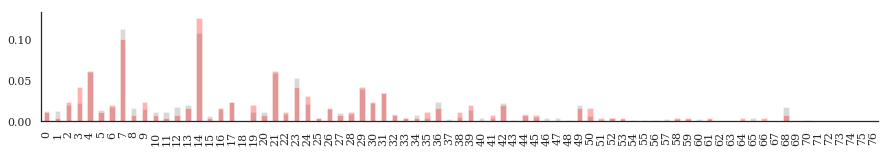

In [170]:
# compare dist
node_probs.plot(kind='bar', color='gray', alpha=.3)
pdm_probs = (
    pdm_sim
    .apply(lambda x: x[0])
    .value_counts(normalize=True)
    .reindex(from_names(voc_nodes), fill_value=0)
)
pdm_probs.plot(kind='bar', color='red', alpha=.3, figsize=(15,2))
sns.despine()
# plt.yscale('log')

In [158]:
# original walks of at least some len, cut off (to catch subsets)


def set_diff(s1, s2):
    ds1 = set([tuple(line) for line in s1.values])
    ds2 = set([tuple(line) for line in s2.values])
    return pd.Series(list(ds1.difference(ds2)))



set_diff(pdm_sim.apply(to_names), pdm4).sample(5)

61     (bucket, grease, line, pump, servo)
24            (hose, hyd, oil, pipe, leak)
114    (engine, coolant, hose, hyd, blown)
69          (filter, hose, hyd, oil, leak)
51       (pto, pump, leak, stick, replace)
dtype: object

In [159]:
C = nx.Graph(cos)
# relabel to int is not deterministic...no gaurantees.
nx.set_node_attributes(C,{i:i for i in C.nodes()}, name='item')
C = nx.relabel_nodes(C, int_map)

# synthesize
m_cos = sample_censored(C, len(pdm4), 4, steps=100, node_prob=node_probs.values)
pdm_cos = pd.Series(m_cos)

0 filter → replace → fitting → pressure
.
.
1 bolts → cab → start → jump
.
.
2 engine → warranty → stick → main
.
.
3 bucket → stick → cylinder → boom
.
.
260 bolts → broken → boom → clamp


In [160]:
def make_experiment(pdm1, pdm2, pdm3, cats=None, cts = [30,30,30]):
    
    if cats is None:
        cats = [1,2,3]
    
    def set_diff(s1, s2):
        ds1 = set([tuple(line) for line in s1.values])
        ds2 = set([tuple(line) for line in s2.values])
        return pd.Series(list(ds1.difference(ds2)))
    
    only1 = pd.DataFrame(dict(m=set_diff(pdm1, pd.concat([pdm2, pdm3])), cat=cats[0]))
    only2 = pd.DataFrame(dict(m=set_diff(pdm2, pd.concat([pdm1, pdm3])), cat=cats[1]))
    only3 = pd.DataFrame(dict(m=set_diff(pdm3, pd.concat([pdm2, pdm1])), cat=cats[2]))
    
    df = pd.concat([only1.sample(cts[0]), only2.sample(cts[1]), only3.sample(cts[2])]).sample(frac=1.)
    return df.reset_index(drop=True)
        
exp = make_experiment(
    pdm4, 
    pdm_sim.apply(to_names), 
    pdm_cos.apply(to_names),
    cats=['real', 'sim', 'cos'],
    cts = [40,30,30],
)
exp.head()

m  cat
0        (ring, replace, stick, cracked)  cos
1   (track, missing, tooth, leak, stick)  sim
2  (step, cracked, stick, replace, leak)  sim
3             (boom, pipe, clamp, loose)  cos
4          (bucket, grease, blown, hose)  cos

#### Reading in Completed Experiment

In [117]:
def read_exp(fname):
    exp = pd.read_csv(f'{fname}_true.csv', index_col=0)
    exp_done = pd.read_csv(f'{fname}_done.csv', index_col=0)
    exp_done['cat'] = exp['cat']
    (exp_done
     .rename(columns={'cat':'Data Type', 
                      'cls': 'Plausibility'}, 
             inplace=True)
    )
    exp_done.replace({'cos':'Cosine', 
                      'sim':'INVITE', 
                      'real':'Real'}, 
                     inplace=True)
    return exp_done

exp_done = pd.concat([
    read_exp('exp2_Mike'), 
#     read_exp('exp1_Mel_ORDER'), 
    read_exp('exp1_Mel_UNORDER'),
],  
    keys=[
        'A', 
        'B',
#         'B-order', 
#         'B-unorder',
    ],
    names=['Expert', 'Obsv']).reset_index()

# pd.DataFrame.reset_index()
# (exp_done
#  .groupby('cat')
#  .cls.value_counts()
#  .groupby(level=0)
#  .apply(lambda x: x / x.sum()).loc[:,1]
# )

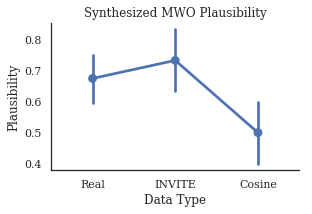

In [118]:
# exp_done
sns.catplot(x='Data Type', y='Plausibility', data=exp_done[exp_done['Expert']=='A'], 
            order=['Real', 'INVITE', 'Cosine'], 
            kind='point', 
#             hue='Expert', 
            ci=75,
            dodge=.1, 
            markers=["o", "s", 'd'], 
            linestyles=["-", "--", '--'], 
            height=3, aspect=1.5)
plt.title('Synthesized MWO Plausibility')
plt.savefig(latex_path/'expert_plaus.png')

In [211]:
sim_samps  = [exp_done[exp_done['cat']=='sim' ]['cls'].sample(frac=1, replace=True).values for _ in range(1000)]
cos_samps  = [exp_done[exp_done['cat']=='cos' ]['cls'].sample(frac=1, replace=True).values for _ in range(1000)]
real_samps = [exp_done[exp_done['cat']=='real']['cls'].sample(frac=1, replace=True).values for _ in range(1000)]

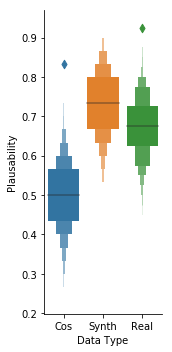

In [212]:
plaus = pd.DataFrame({'Cos': np.array([np.mean(i) for i in cos_samps]),
                      'Synth': np.array([np.mean(i) for i in sim_samps]),
                      'Real':np.array([np.mean(i) for i in real_samps])}).melt(var_name='Data Type', 
                                                                               value_name='Plausability')

sns.catplot(x='Data Type', y='Plausability', data=plaus, kind='boxen', aspect=.5)

# sns.distplot()
# sns.distplot()
# sns.distplot()


### Taxonomy Sandbox

In [222]:


def heymann_taxonomy(dist_mat, cent_prog=nx.betweenness_centrality, tau_pct=50, dynamic=False,
                     create_using=nx.Graph, weighted=True, node_values=None, 
                     dotfile=None, verbose=False, **cent_kws):
    """
    Parameters
    ----------
    dist_mat: pandas.DataFrame
        contains similarity matrix, indexed and named by tags
    cent_prog: str
        algorithm to use in calculating node centrality
        pr: PageRank
        eig: eigencentrality
        btw: betweenness
        cls: closeness
    tau: float
        similarity threshold for retaining a node
    dynamic: bool
        whether to re-calculate centrality after popping every tag
    write_dot: str or None
        file location, where to save a .dot, if any.
    verbose: bool
        print some stuff
    """
    #     tau = 5e-4
#     cent_dict = {
#         'pr': partial(nx.pagerank, max_iter=500),
#         'eig': nx.eigenvector_centrality,
#         'btw': nx.betweenness_centrality,
# #         'cls': nx.closeness_centrality
#     }
    weight=None
    tau = np.percentile(dist_mat,  tau_pct)
    # Create the co-occurence graph, G
    G = create_using(dist_mat)
    G = nx.relabel_nodes(G, dict(zip(G.nodes(), dist_mat.columns)))
    
    if weighted:
        assert cent_prog != nx.closeness_centrality, 'weighted edges are not supported for closeness!' 
        weight='weight'
    
    if node_values is not None:
        if cent_prog != nx.pagerank:
            print('only PR centrality supports node personalization!')
        cent_prog = nx.pagerank
        cent_prog = partial(nx.pagerank, weight=weight, personalization=node_values, **cent_kws)
    else:
        cent_prog = partial(cent_prog, weight=weight, **cent_kws)
    
    # Calculate the centrality of nodes in G
    
    cent = pd.Series(cent_prog(G)).sort_values(ascending=False)
    root = cent.index[0]
    print(f'Root Node: {root}')

    # Init the taxonomy D (DAG)
    D = nx.DiGraph()
    D.add_node(root)

    for n in tqdm(range(dist_mat.shape[0])):

        # Pick the most central node in G, and the node in D most similar to it
        tag = cent.index[0]
        neighbor_sim = {k: dist_mat.loc[tag, k] for k in D.nodes()}
        parent = max(neighbor_sim, key=lambda key: neighbor_sim[key])

        if neighbor_sim[parent] > tau:
            # above threshold--> direct child
            D.add_node(tag)
            D.add_edge(parent, tag)
        else:
            #         D.add_edge(root, descendant)  # do not enforce single taxonomy
            # New "top-level" tag
            D.add_node(tag)
            pass

        if dynamic:
            # recalculate node centralities after removing each <tag>
            # EXPENSIVE.
            G.remove_node(tag)
            cent = pd.Series(cent(G)).sort_values(ascending=False)
        else:
            cent.drop(tag, inplace=True)

    if verbose:
        print(root)  # most "general" topic
        print(nx.isolates(D))  # child-less nodes (i.e. central AND dissimilar)

    D.remove_nodes_from(list(nx.isolates(D)))  # not useful for taxonomy

    if dotfile is not None:
        from networkx.drawing.nx_pydot import graphviz_layout, write_dot
        D.graph['graph'] = {'rankdir': 'LR',
                            'splines': 'true',
                            'ranksep': '4'}
        write_dot(D, dotfile)

    return D

def draw_tax(D):
    D.graph.setdefault('graph', {})['rankdir'] = 'LR'

    subg = [D.subgraph(c) for c in nx.weakly_connected_components(D)]
    fig = plt.figure(tight_layout=True, figsize=(15,20))
    n_rows = 1+len(subg)//2+len(subg)%2
    print(len(subg))
    gs = gridspec.GridSpec(n_rows, 2, 
                           height_ratios=[3]+(n_rows-1)*[1])

    for n, d in enumerate(sorted(subg, key=len, reverse=True)):
        if n==0:
            ax = fig.add_subplot(gs[:n+1, :])
        else:
            ax = fig.add_subplot(gs[(n+1)//2, (n+1)%2])
        nx.draw_networkx(d, ax=ax,
                         pos=nx.drawing.nx_pydot.pydot_layout(d, prog='dot'),
                         node_size=0,edge_color='dodgerblue')
        plt.axis('off')

Root Node: steel


7


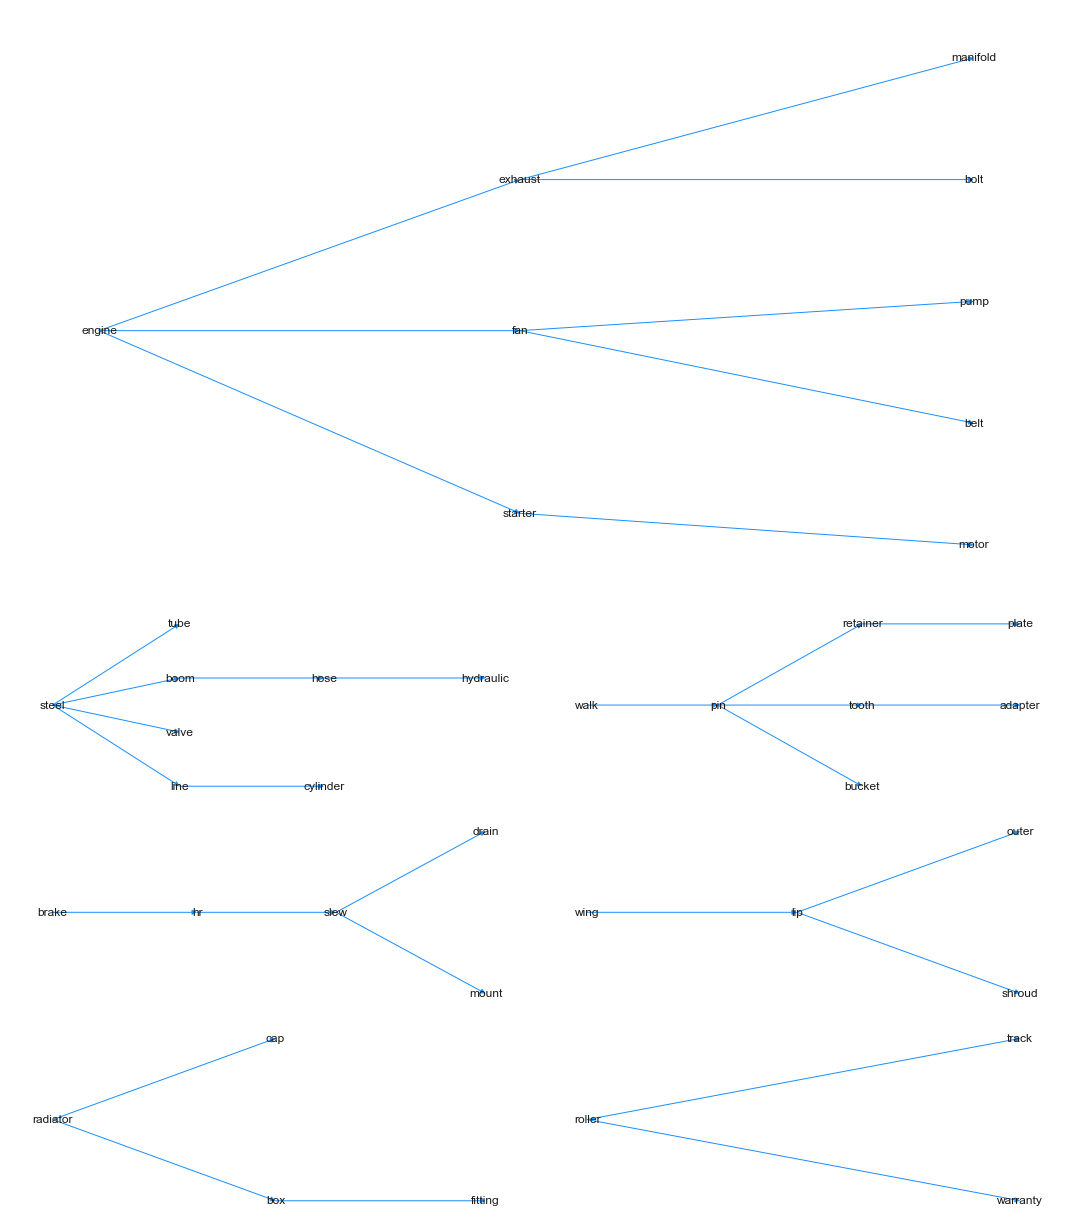

In [229]:
hey_man = partial(heymann_taxonomy, 
                  tau_pct = 85,
                  dynamic=False, 
                  weighted=True, 
#                   node_values=filt_tags.sum().to_dict(),
#                   max_iter=1000,
#                   alpha=.95,
                 )

tax = hey_man(log['Cosine']['thres'])
draw_tax(tax)
# draw_tax(nx.minimum_spanning_tree(G).to_directed())

In [62]:
tax_ivt = hey_man(adj_ivt, 
                  create_using=nx.DiGraph, 
#                   cent_prog=nx.current_flow_betweenness_centrality
#                   node_values=filt_tags.sum().to_dict()
                 )
draw_tax(tax_ivt)

NameError: name 'adj_ivt' is not defined

Root Node: air



4


/home/tbsexton/anaconda3/envs/eng-net/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


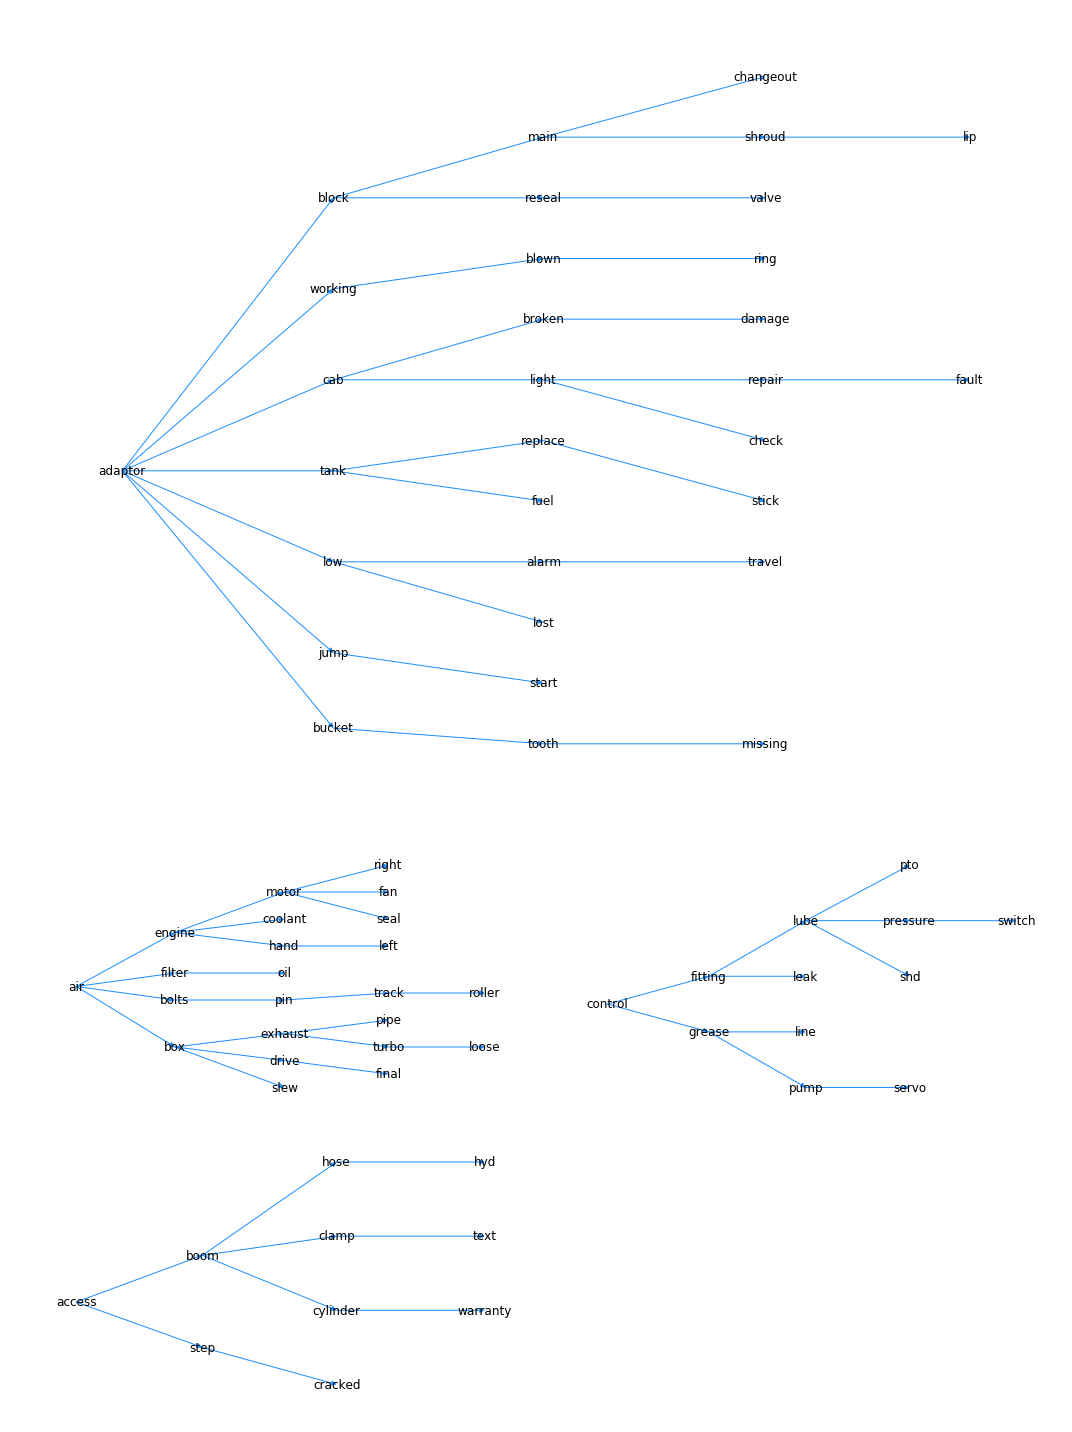

In [61]:
tax_ivt = hey_man(adj_ivt.T, create_using=nx.DiGraph) 
draw_tax(tax_ivt)